In [2]:
import numpy as np
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession 
import pyspark.sql.functions as F

spark = SparkSession.builder.appName('flights14').getOrCreate()

plt.rcParams.update(**{'figure.dpi':150})

In [4]:
df = spark.read.csv('flights14.csv',inferSchema=True,header=True)
df.show(5)

+----+-----+---+---------+---------+-------+------+----+--------+--------+----+
|year|month|day|dep_delay|arr_delay|carrier|origin|dest|air_time|distance|hour|
+----+-----+---+---------+---------+-------+------+----+--------+--------+----+
|2014|    1|  1|       14|       13|     AA|   JFK| LAX|     359|    2475|   9|
|2014|    1|  1|       -3|       13|     AA|   JFK| LAX|     363|    2475|  11|
|2014|    1|  1|        2|        9|     AA|   JFK| LAX|     351|    2475|  19|
|2014|    1|  1|       -8|      -26|     AA|   LGA| PBI|     157|    1035|   7|
|2014|    1|  1|        2|        1|     AA|   JFK| LAX|     350|    2475|  13|
+----+-----+---+---------+---------+-------+------+----+--------+--------+----+
only showing top 5 rows



## Preliminary checks

In [5]:
# number of observations
df.count()

253316

In [6]:
# check data types
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)
 |-- dep_delay: integer (nullable = true)
 |-- arr_delay: integer (nullable = true)
 |-- carrier: string (nullable = true)
 |-- origin: string (nullable = true)
 |-- dest: string (nullable = true)
 |-- air_time: integer (nullable = true)
 |-- distance: integer (nullable = true)
 |-- hour: integer (nullable = true)



In [8]:
# check for missing values

def nullValues(df):
    out = []
    
    for column in df.columns:
        n_missing = df.where(F.col(column).isNull()).count()
        out.append((column,n_missing))
    
    return out

null_list = nullValues(df)
spark.createDataFrame(null_list,schema=['Column','num_missing']).show()

+---------+-----------+
|   Column|num_missing|
+---------+-----------+
|     year|          0|
|    month|          0|
|      day|          0|
|dep_delay|          0|
|arr_delay|          0|
|  carrier|          0|
|   origin|          0|
|     dest|          0|
| air_time|          0|
| distance|          0|
|     hour|          0|
+---------+-----------+



## Task 1

Show all origin-destination pairs with distance > 2500 miles.

In [9]:
(
    df.select('origin','dest','distance')
    .filter("distance > 2500")
    .dropDuplicates()
).show()

+------+----+--------+
|origin|dest|distance|
+------+----+--------+
|   JFK| SFO|    2586|
|   JFK| OAK|    2576|
|   EWR| HNL|    4962|
|   EWR| HNL|    4963|
|   JFK| HNL|    4983|
|   EWR| SFO|    2565|
|   JFK| SJC|    2569|
|   JFK| SMF|    2521|
|   EWR| ANC|    3370|
+------+----+--------+



## Task 2

(a) Count the number of flights for each carrier

(b) Repeat (a) but seperate the number from each origin airport

In [10]:
## number of flights for each carrier
df.groupBy('carrier').count().show()

+-------+-----+
|carrier|count|
+-------+-----+
|     UA|46267|
|     AA|26302|
|     EV|39819|
|     B6|44479|
|     DL|41683|
|     OO|  200|
|     F9|  473|
|     US|16750|
|     MQ|18559|
|     HA|  260|
|     AS|  574|
|     FL| 1251|
|     VX| 4797|
|     WN|11902|
+-------+-----+



In [11]:
## number of flights for each carrier from each origin airpot
(
    df
    .groupBy('carrier')
    .pivot('origin')
    .count()
).show()


+-------+-----+-----+-----+
|carrier|  EWR|  JFK|  LGA|
+-------+-----+-----+-----+
|     UA|36124| 3924| 6219|
|     AA| 2649|11923|11730|
|     EV|28328| 1069|10422|
|     B6| 5473|34220| 4786|
|     DL| 4153|18860|18670|
|     OO|    1| null|  199|
|     F9| null| null|  473|
|     US| 3480| 2645|10625|
|     MQ|  167| 5444|12948|
|     HA| null|  260| null|
|     AS|  574| null| null|
|     FL| null| null| 1251|
|     VX| 1644| 3138|   15|
|     WN| 4807| null| 7095|
+-------+-----+-----+-----+



## Task 3


(a) Calculate the statistics of `dep_delay` of flights from each airport

(b) Repeat (a) but group by the carrier as well

In [28]:
# by airport
(
    df
    .groupBy('origin')
    .agg(
        F.count("*").alias("count"),
        F.mean('dep_delay').alias('mean'),
        F.min('dep_delay').alias('min'),
        F.percentile_approx('dep_delay',0.25).alias('25%'),
        F.percentile_approx('dep_delay',0.25).alias('50%'),
        F.percentile_approx('dep_delay',0.25).alias('75%'),
        F.max('dep_delay').alias('max')
    )
).show()

+------+-----+------------------+----+---+---+---+----+
|origin|count|              mean| min|25%|50%|75%| max|
+------+-----+------------------+----+---+---+---+----+
|   LGA|84433|10.605000414529863|-112| -6| -6| -6| 973|
|   EWR|87400|15.212482837528604| -27| -4| -4| -4|1498|
|   JFK|81483|11.446166685075415| -34| -5| -5| -5|1241|
+------+-----+------------------+----+---+---+---+----+



In [32]:
(
    df
    .groupBy('carrier','origin')
    .agg(
        F.count("*").alias("count"),
        F.mean('dep_delay').alias('mean'),
        F.min('dep_delay').alias('min'),
        F.percentile_approx('dep_delay',0.25).alias('25%'),
        F.percentile_approx('dep_delay',0.25).alias('50%'),
        F.percentile_approx('dep_delay',0.25).alias('75%'),
        F.max('dep_delay').alias('max')
    )
    .sort('carrier')
).show(42)

+-------+------+-----+------------------+----+---+---+---+----+
|carrier|origin|count|              mean| min|25%|50%|75%| max|
+-------+------+-----+------------------+----+---+---+---+----+
|     AA|   EWR| 2649|13.343525858814647| -27| -6| -6| -6|1498|
|     AA|   JFK|11923| 9.654952612597501| -16| -5| -5| -5|1241|
|     AA|   LGA|11730| 6.255839727195226| -20| -7| -7| -7| 971|
|     AS|   EWR|  574| 8.831010452961673| -21| -8| -8| -8| 341|
|     B6|   JFK|34220|12.291613091759205| -18| -4| -4| -4| 594|
|     B6|   LGA| 4786| 11.81216046803176| -25| -7| -7| -7| 478|
|     B6|   EWR| 5473|10.267860405627626| -24| -8| -8| -8| 472|
|     DL|   JFK|18860|12.454135737009544| -34| -4| -4| -4|1014|
|     DL|   EWR| 4153|14.961714423308452| -16| -3| -3| -3|1087|
|     DL|   LGA|18670|11.350830208891269|-112| -5| -5| -5| 973|
|     EV|   LGA|10422| 18.32767223181731| -27| -6| -6| -6| 665|
|     EV|   JFK| 1069|19.818521983161833| -19| -6| -6| -6| 435|
|     EV|   EWR|28328|17.194154193730583

## Task 4

Randomly sample 5 observations for each origin airport

**Note**: This is the best I could come up with.

In [33]:
from pyspark.sql import Window

In [35]:
window_random = Window.partitionBy(F.col('origin')).orderBy(F.rand())
df.withColumn('rank', F.rank().over(window_random)).filter(F.col('rank') <= 5).drop('rank').show()

+----+-----+---+---------+---------+-------+------+----+--------+--------+----+
|year|month|day|dep_delay|arr_delay|carrier|origin|dest|air_time|distance|hour|
+----+-----+---+---------+---------+-------+------+----+--------+--------+----+
|2014|    3| 20|       -5|        2|     AA|   LGA| DFW|     213|    1389|   5|
|2014|    7|  3|      195|      193|     DL|   LGA| MIA|     159|    1096|  22|
|2014|    9|  5|       -9|        1|     US|   LGA| DCA|      40|     214|   5|
|2014|    7|  9|       24|       25|     MQ|   LGA| SDF|     112|     659|  15|
|2014|    9|  1|       -5|      -17|     DL|   LGA| MSP|     135|    1020|   8|
|2014|    8| 11|       51|       43|     UA|   EWR| DFW|     189|    1372|  14|
|2014|    9| 12|        3|        9|     US|   EWR| MIA|     157|    1085|  19|
|2014|   10|  8|        2|       -3|     EV|   EWR| CLT|      86|     529|  21|
|2014|    3|  5|       -3|       -3|     UA|   EWR| SFO|     364|    2565|  20|
|2014|    4| 18|       -4|      -20|    

## Task 5

Find the top 5 destination airports.

In [36]:
df.groupby('dest').count().orderBy(F.col('count').desc()).show(5)

+----+-----+
|dest|count|
+----+-----+
| LAX|14434|
| ATL|12808|
| SFO|11907|
| MCO|11709|
| BOS|11609|
+----+-----+
only showing top 5 rows



## Task 6

Find the top 3 origin-dest pairs with maximum number of flights between them

In [37]:
# second approach - group by
(
    df
    .groupBy('origin','dest')
    .count()
    .orderBy(F.col('count').desc())
).show(3)

+------+----+-----+
|origin|dest|count|
+------+----+-----+
|   JFK| LAX|10208|
|   JFK| SFO| 7368|
|   LGA| ORD| 7052|
+------+----+-----+
only showing top 3 rows



## Task 7

For each origin airport, plot the total number of departing flights each day in the month of June.

In [41]:
new_df = (
    df
    .filter('month==6')
    .groupBy('origin','day')
    .count()
    .sort('origin','day')
).toPandas()
new_df

,origin,day,count
0,EWR,1,276
1,EWR,2,314
2,EWR,3,291
3,EWR,4,309
4,EWR,5,331
...,...,...,...
85,LGA,26,325
86,LGA,27,324
87,LGA,28,208
88,LGA,29,266


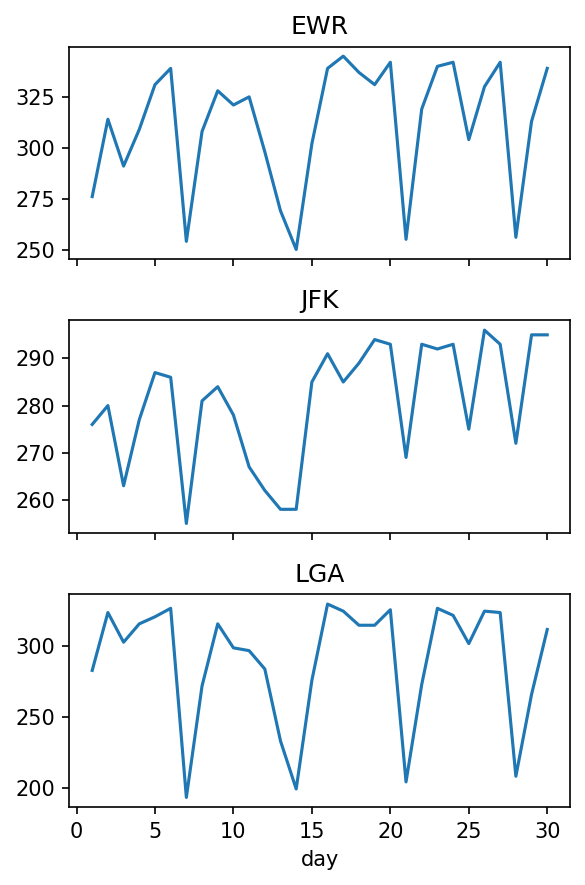

In [42]:
grouped = new_df.groupby('origin')

n_cols= 1
n_rows = len(grouped)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(4*n_cols,2*n_rows), sharex=True)

for (key, ax) in zip(grouped.groups.keys(), axs.flatten()):
    grouped.get_group(key).plot(ax=ax,x='day',y='count',legend=False)
    _ = ax.set_title(key)
    
fig.tight_layout()

## Task 8

Find the number of unique routes served by each carrier

In [43]:
(
    df
    .select('carrier',F.concat_ws('_',F.col('origin'),F.col('dest')).alias('orig_dest'))
    .groupBy('carrier')
    .agg(F.countDistinct('orig_dest').alias('num_uniq_routes'))
).show()

+-------+---------------+
|carrier|num_uniq_routes|
+-------+---------------+
|     UA|             48|
|     AA|             24|
|     EV|            103|
|     B6|             56|
|     DL|             56|
|     OO|              3|
|     F9|              2|
|     US|             12|
|     MQ|             32|
|     HA|              1|
|     AS|              1|
|     FL|              2|
|     VX|              7|
|     WN|             16|
+-------+---------------+



## Task 9

Rate the carriers according to 
1. total distance flown
2. average distances flown per flight

In [45]:
res = (
    df.
    select('carrier','distance')
    .groupBy('carrier')
    .agg(
        F.sum('distance').alias('Total'),
        F.mean('distance').alias('Average')
    )
)

# sorted by total distance
res.orderBy(F.col('Total').desc()).show()

+-------+--------+------------------+
|carrier|   Total|           Average|
+-------+--------+------------------+
|     UA|72155634|1559.5485767393607|
|     DL|52575904|1261.3272557157595|
|     B6|47554862|1069.1531284426358|
|     AA|36407712|1384.2183864344918|
|     EV|22510199| 565.3130163992064|
|     VX|11980325|2497.4619553887846|
|     WN|11715150| 984.3009578222147|
|     MQ|10023882| 540.1089498356592|
|     US| 9178227| 547.9538507462687|
|     AS| 1378748|            2402.0|
|     HA| 1295580|            4983.0|
|     FL|  828067| 661.9240607513989|
|     F9|  759054|1604.7653276955602|
|     OO|  143735|           718.675|
+-------+--------+------------------+



In [46]:
# sorted by average distance
res.orderBy(F.col('Average').desc()).show()

+-------+--------+------------------+
|carrier|   Total|           Average|
+-------+--------+------------------+
|     HA| 1295580|            4983.0|
|     VX|11980325|2497.4619553887846|
|     AS| 1378748|            2402.0|
|     F9|  759054|1604.7653276955602|
|     UA|72155634|1559.5485767393607|
|     AA|36407712|1384.2183864344918|
|     DL|52575904|1261.3272557157595|
|     B6|47554862|1069.1531284426358|
|     WN|11715150| 984.3009578222147|
|     OO|  143735|           718.675|
|     FL|  828067| 661.9240607513989|
|     EV|22510199| 565.3130163992064|
|     US| 9178227| 547.9538507462687|
|     MQ|10023882| 540.1089498356592|
+-------+--------+------------------+



## Task 10:

Among flights that had delayed departures, find the percentage of flights that arrived early or on time at the destination (`arr_delay <= 0`)

In [50]:
(
    df
    .filter('dep_delay>0')
    .withColumn('ontime',F.when(F.col('arr_delay')<=0,1).otherwise(0))
    .agg(F.mean('ontime'))
).collect()[0][0]*100

26.745718050065875